## Parameter optimization for accuracy, speed and memory usage
The used dataset is bursi. The following optimizations are computed on Ubuntu 14.04, CPU: Intel i5-6600@3.3GHz, 16 GB RAM
The results are stored in files and only a visualization is done here. The benchmark is computed with the script runBenchmark.sh.

In [1]:
%matplotlib inline
%load_ext memory_profiler
from bioinf_learn import MinHash
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import time
import math
from collections import Counter
import gc

import os.path
import cPickle as pickle

In [2]:
def compute_score(error_list, memory_list, time_list, max_memory, max_time, alpha, beta):
    score_values = []
    for error_, memory_, time_ in zip(error_list, memory_list, time_list):
        error = error_/(float (max_error))
        if memory_ == 0: 
            score_values.append(5)
            continue
        else:
            memory = math.log(memory_/float(max_memory), 10)*alpha
        time = math.log(time_/float(max_time), 10)*beta
        score_values.append(error + memory  + time)
    score_values_np = np.array(score_values)
    min_values_index = np.array(np.where(score_values_np == score_values_np.min()))
    min_values = score_values_np.min()
    return min_values, min_values_index, score_values

In [3]:
def relative_error_reduction(max_error, new_error):
#     print max_error
#     print new_error
#     print "rel: ", (max_error - new_error)/float(max_error)
    return (max_error - new_error)/float(max_error)

In [4]:
def getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list):
    memory_list = []
    for dist in distribution_pruning:
        memory = 0
        for j in dist[0][0]:
            memory += j * dist[0][0][j]
        memory_list.append(memory)
    tmp_memory = []
    tmp_index = []
    tmp_fitting_time = []
    tmp_query_time = []
    tmp_error_list = []
    relative_error_reduction_list = []
    for i in xrange(len(memory_list)):
        if memory_list[i] != 0:
            tmp_memory.append(memory_list[i])
            tmp_index.append(iteration_value_list[i])
            tmp_fitting_time.append(time_fit_list[i])
            tmp_error_list.append(error_list[i])
            tmp_query_time.append(time_kneighbors_list[i])
            value_relative_error = relative_error_reduction(max_error, error_list[i])
            relative_error_reduction_list.append(value_relative_error)
    memory_list = tmp_memory
    iteration_value_list = tmp_index
    time_fit_list = tmp_fitting_time
    error_list = tmp_error_list
    time_kneighbors_list = tmp_query_time
    return memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list

In [5]:
def computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time):
    min_error_value = 1
    best_alpha = 0
    best_beta = 0
    best_score = 0
    best_pruning_value = 0
    plotting_values = []
    epsilon = 0.05 # allow a variance of factor epsilon for the error value
    for alpha_ in [0.5]:
        for beta_ in [0.1]:
            result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
    #         print error_list[result[1][0][0]]
            if max_error + epsilon > error_list[result[1][0][0]]:
                if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                    best_score = result[0]
                    best_alpha = alpha_
                    best_beta = beta_
                    min_error_value = error_list[result[1][0][0]]
                    best_pruning_value = result[1][0][0]
                    plotting_values.append([best_score, min_error_value, best_alpha, best_beta, result[1][0][0]])
    return [best_score, best_alpha, best_beta, best_pruning_value], plotting_values

In [6]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def createPlot(x_values_list, accuracy, time_fit, time_kneighbors, relative_error_reduction,
               xlabel, ylabelAccuracy, ylabelFit, ylabelKneighbors, ylabel_relative_error_reduction,
              mean=None, std=None, fig_size=None):
    if fig_size != None:
        plt.figure(figsize=fig_size)
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    #par3 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.2))
    #par3.spines["right"].set_position(("axes", 1.4))

    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    #make_patch_spines_invisible(par3)

    # Second, show the right spine.
    par2.spines["right"].set_visible(True)
    #par3.spines["right"].set_visible(True)


    p1, = host.plot(x_values_list, accuracy, "b-")
    p2, = par1.plot(x_values_list, time_fit, "r-")
    p3, = par2.plot(x_values_list, time_kneighbors, "g-")
    #p4, = par3.plot(x_values_list, relative_error_reduction, "m-")


    host.set_xlim(min(x_values_list), max(x_values_list))
    host.set_ylim(min(accuracy), max(accuracy))
    par1.set_ylim(min(time_fit), max(time_fit))
    par2.set_ylim(min(time_kneighbors), max(time_kneighbors))
    #par3.set_ylim(min(relative_error_reduction), max(relative_error_reduction))


    host.set_xlabel(xlabel)
    host.set_ylabel(ylabelAccuracy)
    par1.set_ylabel(ylabelFit)
    par2.set_ylabel(ylabelKneighbors)
    #par3.set_ylabel(ylabel_relative_error_reduction)


    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    # par3.yaxis.label.set_color(p4.get_color())


    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    #par3.tick_params(axis='y', colors=p4.get_color(), **tkw)

    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]#, p4]
    plt.rcParams.update({'font.size': 14})

    plt.show()

In [7]:
def plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, iteration_value_list,
              xlabel, ylabel):
    result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, 
                       alpha=best_values[1], beta=best_values[2])
    plt.plot(iteration_value_list, result[2], 'k-', lw=2)
    plt.rcParams.update({'font.size': 14})

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with score: ", result[0]
    print "alpha: ", best_values[1]
    print "beta: ", best_values[2]

### Distribution of the inverse index

In [8]:
input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/init_values"
if os.path.isfile(input_file_name):
    fileObject = open(input_file_name,'r')
    distribution = pickle.load(fileObject)

In [9]:
min_ = min(distribution[0][0])
max_ = max(distribution[0][0])

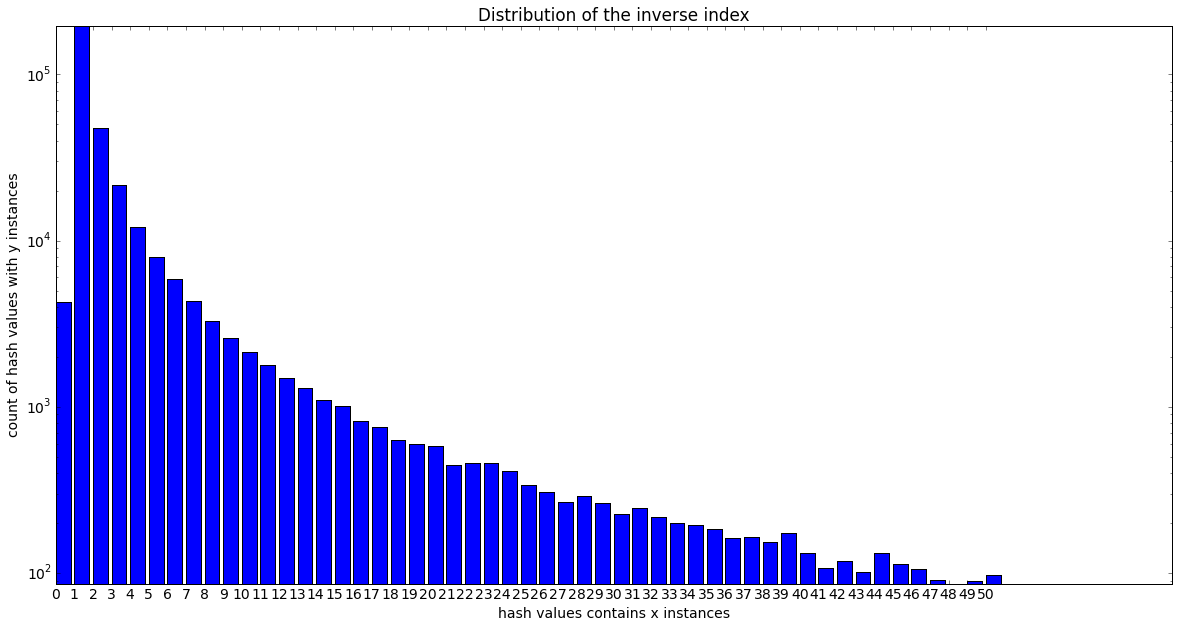

In [12]:
X = np.arange(len(distribution[0][0]))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(X, distribution[0][0].values())
plt.xticks(X, distribution[0][0].keys())
ymax = max(distribution[0][0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.rcParams.update({'font.size': 14})

plt.show()

(array([ 2,  2,  2,  9, 17, 24, 39, 69, 84, 93, 42, 16,  0]), array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300]))


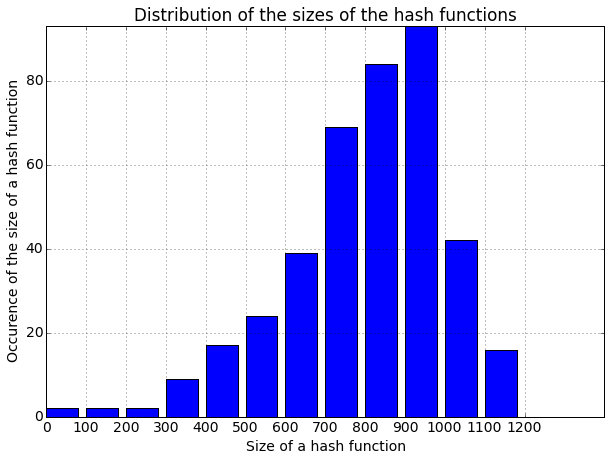

In [40]:
# print distribution[0][1]
dist =  np.histogram(distribution[0][1], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
values = 0
for i in distribution[0][0]:
    values += distribution[0][0][i]

print dist
# print values

data = np.arange(len(dist[0]))
plt.figure(figsize=(10, 7))
# plt.yscale('log')
plt.bar(data, dist[0])
plt.xticks(data, dist[1])
ymax = max(dist[0])
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("Occurence of the size of a hash function")
plt.xlabel("Size of a hash function")
plt.title("Distribution of the sizes of the hash functions")
plt.rcParams.update({'font.size': 14})
plt.show()


### WTA-Hash index

In [84]:
input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/init_values_wta"
if os.path.isfile(input_file_name):
    fileObject = open(input_file_name,'r')
    distribution = pickle.load(fileObject)

In [85]:
min_ = min(distribution[0][0])
max_ = max(distribution[0][0])

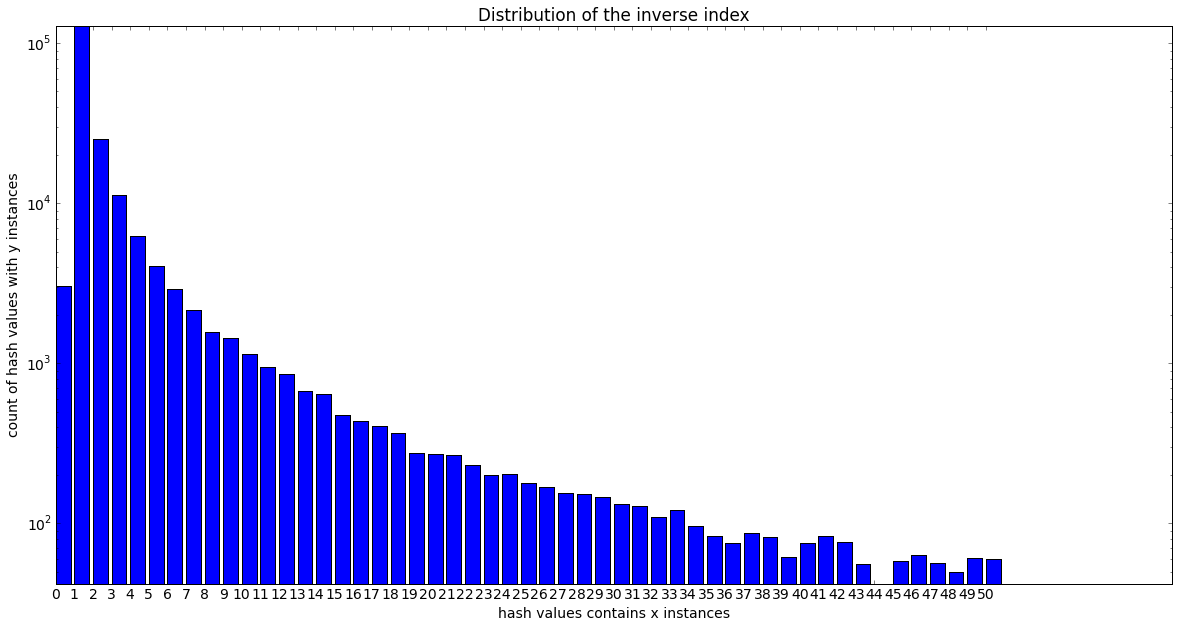

In [86]:
X = np.arange(len(distribution[0][0]))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(X, distribution[0][0].values())
plt.xticks(X, distribution[0][0].keys())
ymax = max(distribution[0][0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.rcParams.update({'font.size': 14})

plt.show()

(array([ 0,  1, 67, 90, 69, 55, 50, 38, 19, 10,  1,  0,  0]), array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300]))


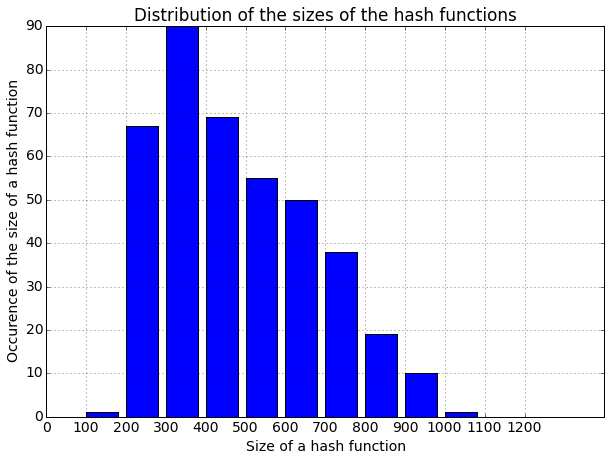

In [89]:
# print distribution[0][1]
dist =  np.histogram(distribution[0][1], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
values = 0
for i in distribution[0][0]:
    values += distribution[0][0][i]

print dist
# print values

data = np.arange(len(dist[0]))
plt.figure(figsize=(10, 7))
# plt.yscale('log')
plt.bar(data, dist[0])
plt.xticks(data, dist[1])
ymax = max(dist[0])
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("Occurence of the size of a hash function")
plt.xlabel("Size of a hash function")
plt.title("Distribution of the sizes of the hash functions")
plt.rcParams.update({'font.size': 14})
plt.show()

### Compute the maximum values for time, memory usage and the error value

In [33]:
max_error = 1 - distribution[3]
max_time = distribution[2]
memory_list = []
max_memory = 0
for i in distribution[0][0]:
    memory_list.append(distribution[0][0][i])
    max_memory += i*distribution[0][0][i]

### Best pruning value for the frequency of occurences of hash values

In [43]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
index_shift = 1
for i in xrange(1, 52):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/prune_index_frequencey+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

In [44]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index after pruning hash values with an occurence less than n

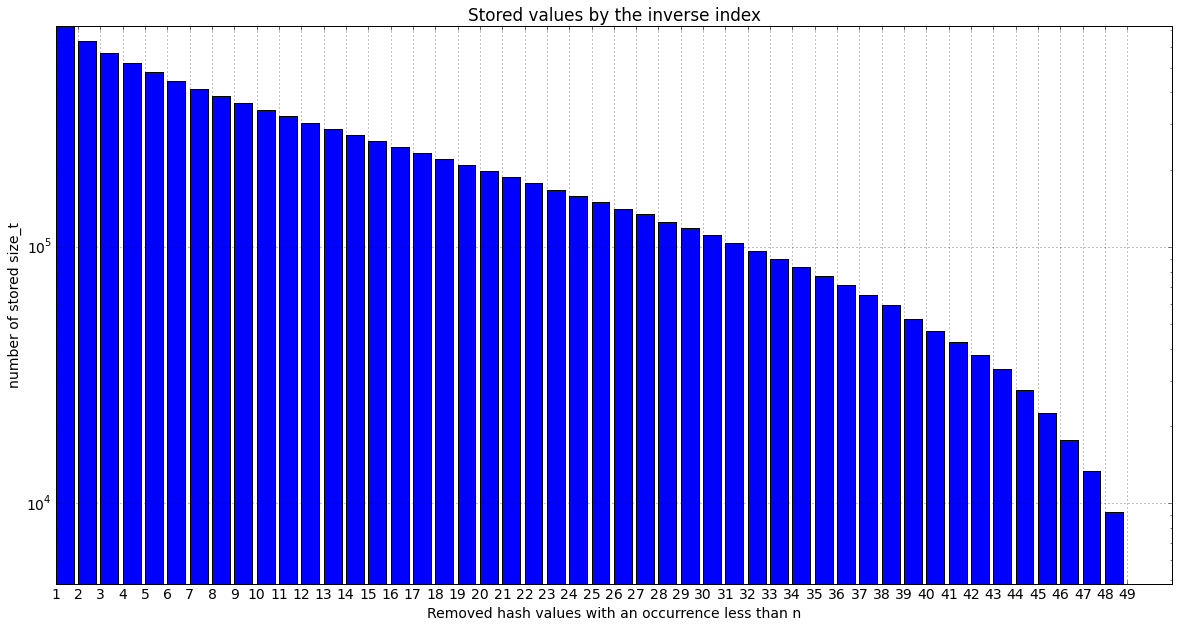

In [45]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Removed hash values with an occurrence less than n")
plt.title("Stored values by the inverse index")
plt.rcParams.update({'font.size': 14})
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

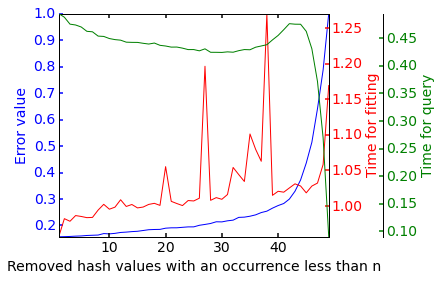

In [46]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Removed hash values with an occurrence less than n", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [94]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  1033  with score:  0.702051342378
alpha:  0.5
beta:  0.1


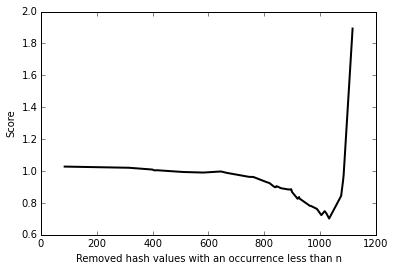

In [95]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, iteration_value_list,
              "Removed hash values with an occurrence less than n", "Score")

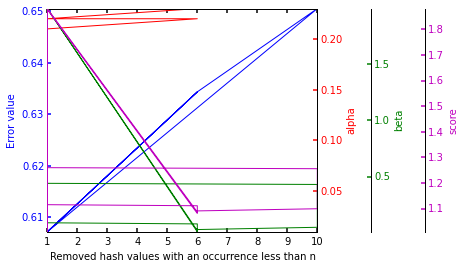

In [18]:
alpha_values = []
beta_values = []
error_values = []
score_values = []
iteration_values = []
for i in plotValues:
    alpha_values.append(i[2])
    beta_values.append(i[3])
    error_values.append(i[1])
    score_values.append(i[0])
    iteration_values.append(iteration_value_list[i[4]])
createPlot(iteration_values, error_values, alpha_values, beta_values, score_values,
           "Removed hash values with an occurrence less than n", "Error value",
           "alpha", "beta", "score")

### Removing hash functions with less hash values than n

In [47]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
index_shift = 1
iteration_value = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
iteration_value_list = []
for i in iteration_value:
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_function_pruned+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

In [48]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index after pruning

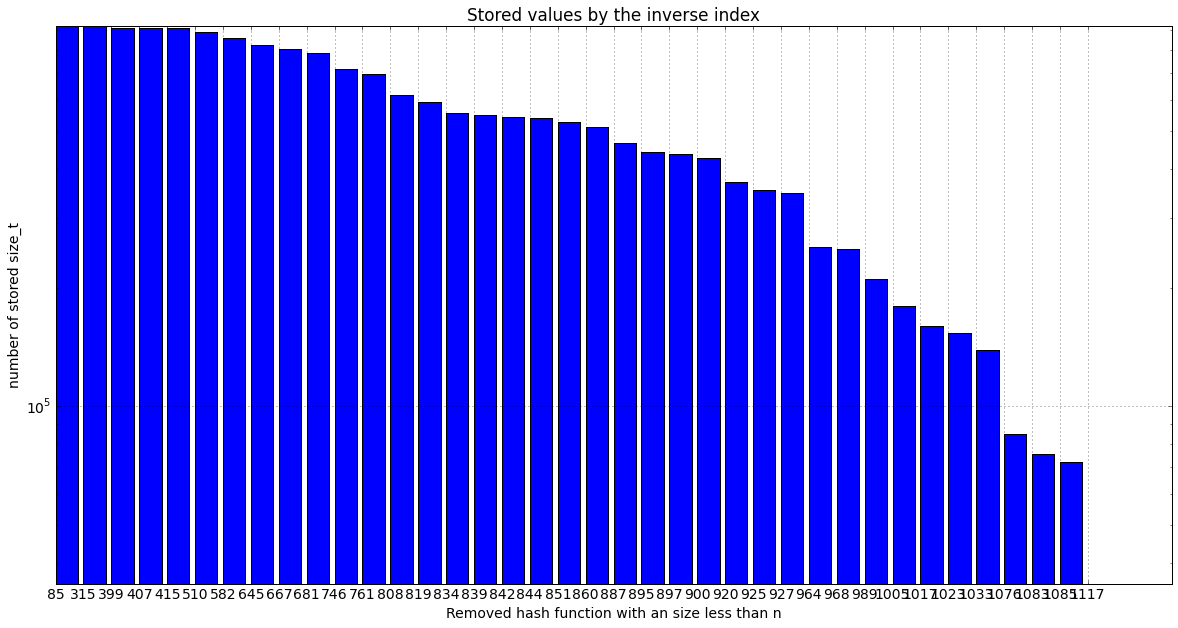

In [49]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Removed hash function with an size less than n")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

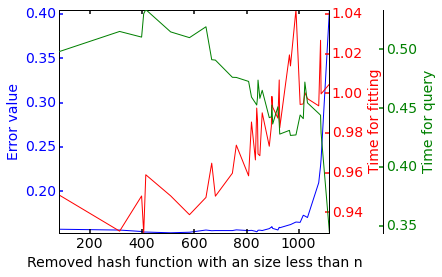

In [50]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Removed hash function with an size less than n", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [90]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  1033  with score:  0.702051342378
alpha:  0.5
beta:  0.1


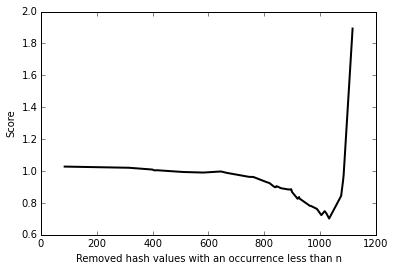

In [91]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, iteration_value_list,
              "Removed hash values with an occurrence less than n", "Score")

### Influence of shingels

#### Concaternate values of a shingleton

In [81]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
for i in xrange(1, 6):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/shingle_concat+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

In [82]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

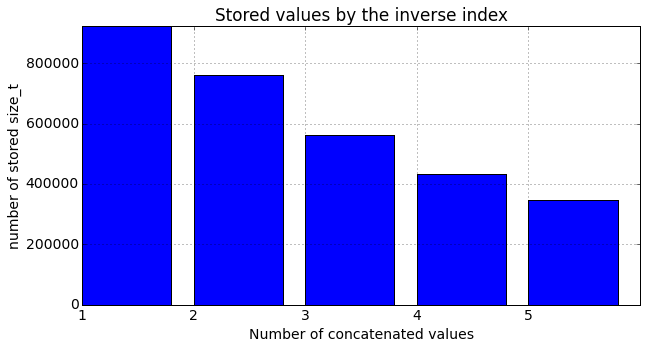

In [83]:
data = np.arange(len(memory_list))
plt.figure(figsize=(10, 5))
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Number of concatenated values")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

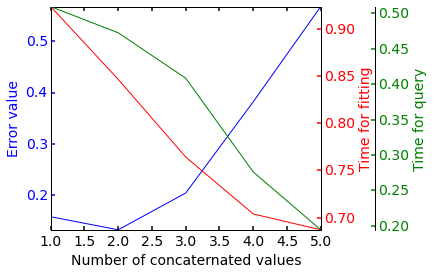

In [55]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Number of concaternated values", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [29]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  5  with score:  1.75507172824
alpha:  1.99
beta:  1.99


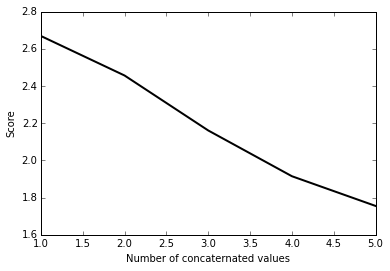

In [30]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, iteration_value_list,
              "Number of concaternated values", "Score")

#### Take minimum value of shingelton

In [46]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
for i in xrange(1, 6):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/shingle_min_val+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

In [47]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

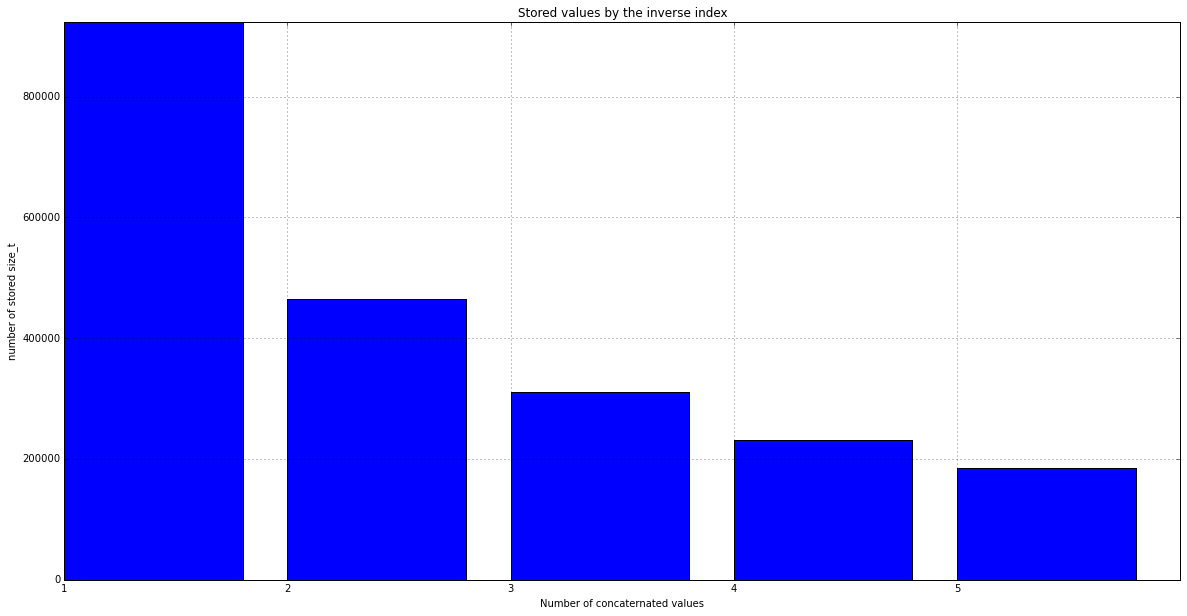

In [48]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Number of concaternated values")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

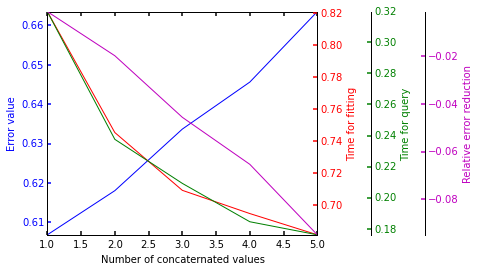

In [49]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Number of concaternated values", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [50]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  4  with score:  1.04066541614
alpha:  0.3
beta:  0.06


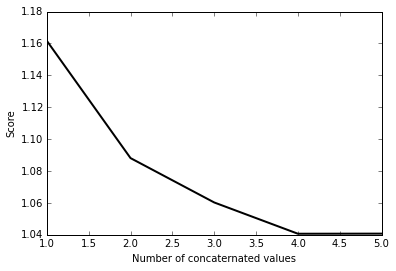

In [51]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, iteration_value_list,
              "Number of concaternated values", "Score")

### Frequencey of pruning

#### Removing hash functions with less hash values than n

In [71]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
index_shift = 1
frequency_pruning = [0.1, 0.5]
for i in frequency_pruning:
    for j in xrange(1, 10):
        input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/freqency_pruning_and_occurences+"+str(i)+ "+" +str(j)
        if os.path.isfile(input_file_name):
            fileObject = open(input_file_name,'r')
            dist_tmp = pickle.load(fileObject)
            distribution_pruning.append(dist_tmp)
            error_list.append(1 - dist_tmp[3])
            time_fit_list.append(dist_tmp[1])
            time_kneighbors_list.append(dist_tmp[2])
            iteration_value_list.append([i,j])


In [72]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

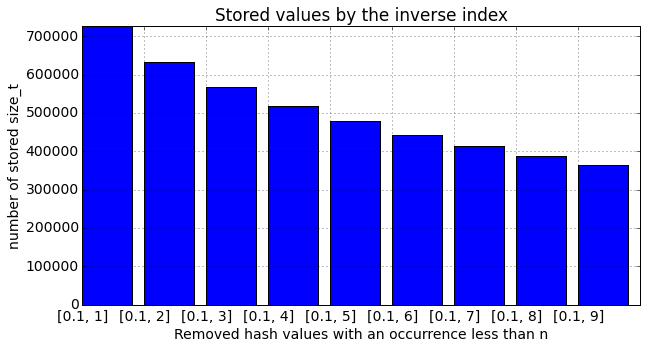

In [79]:
data = np.arange(len(memory_list))
plt.figure(figsize=(10, 5))
# plt.yscale('log')
plt.bar(data[:9], memory_list[:9])
plt.xticks(data[:9], iteration_value_list[:9])
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Removed hash values with an occurrence less than n")
plt.title("Stored values by the inverse index")
plt.show()

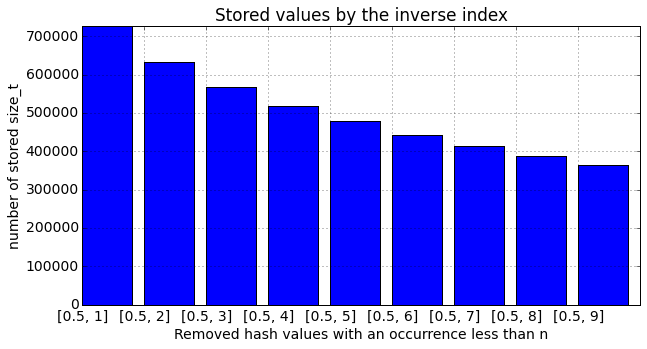

In [80]:
data = np.arange(len(memory_list))
plt.figure(figsize=(10, 5))
# plt.yscale('log')
plt.bar(data[9:], memory_list[9:])
plt.xticks(data[9:], iteration_value_list[9:])
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Removed hash values with an occurrence less than n")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

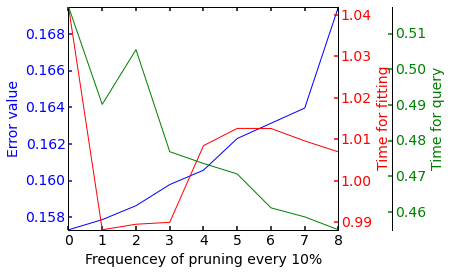

In [61]:
createPlot(range(len(iteration_value_list[:9])), error_list[:9], time_fit_list[:9], time_kneighbors_list[:9], relative_error_reduction_list[:9],
           "Frequencey of pruning every 10%", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

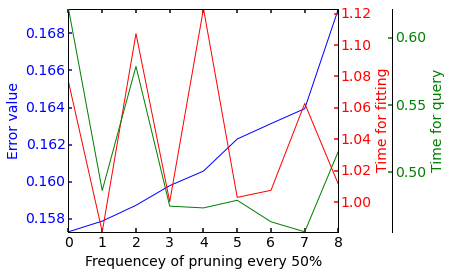

In [62]:
createPlot(range(len(iteration_value_list[9:])), error_list[9:], time_fit_list[9:], time_kneighbors_list[9:], relative_error_reduction_list[9:],
           "Frequencey of pruning every 50%", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [102]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  8  with score:  0.883244382645
alpha:  0.5
beta:  0.1


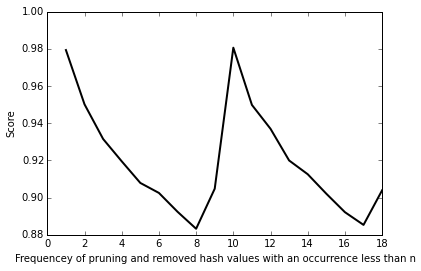

In [103]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, 
           range(1,len(iteration_value_list)+1),
              "Frequencey of pruning and removed hash values with an occurrence less than n", "Score")

#### Best pruning value for the frequency of occurences of hash values

In [64]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
index_values = []
frequency_pruning = [0.1, 0.3, 0.5, 0.7, 1]
iteration_value_list = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
for i in frequency_pruning:
    for j in iteration_value:
        
        input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/frequencey_pruning_and_size_hash_values+"+str(i)+ "+" +str(j)
        if os.path.isfile(input_file_name):
            fileObject = open(input_file_name,'r')
            dist_tmp = pickle.load(fileObject)
            distribution_pruning.append(dist_tmp)
            error_list.append(1 - dist_tmp[3])
            time_fit_list.append(dist_tmp[1])
            time_kneighbors_list.append(dist_tmp[2])
            iteration_value_list.append([i,j])

# print len(distribution_pruning)
# print distribution_pruning
# print error_list

In [65]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

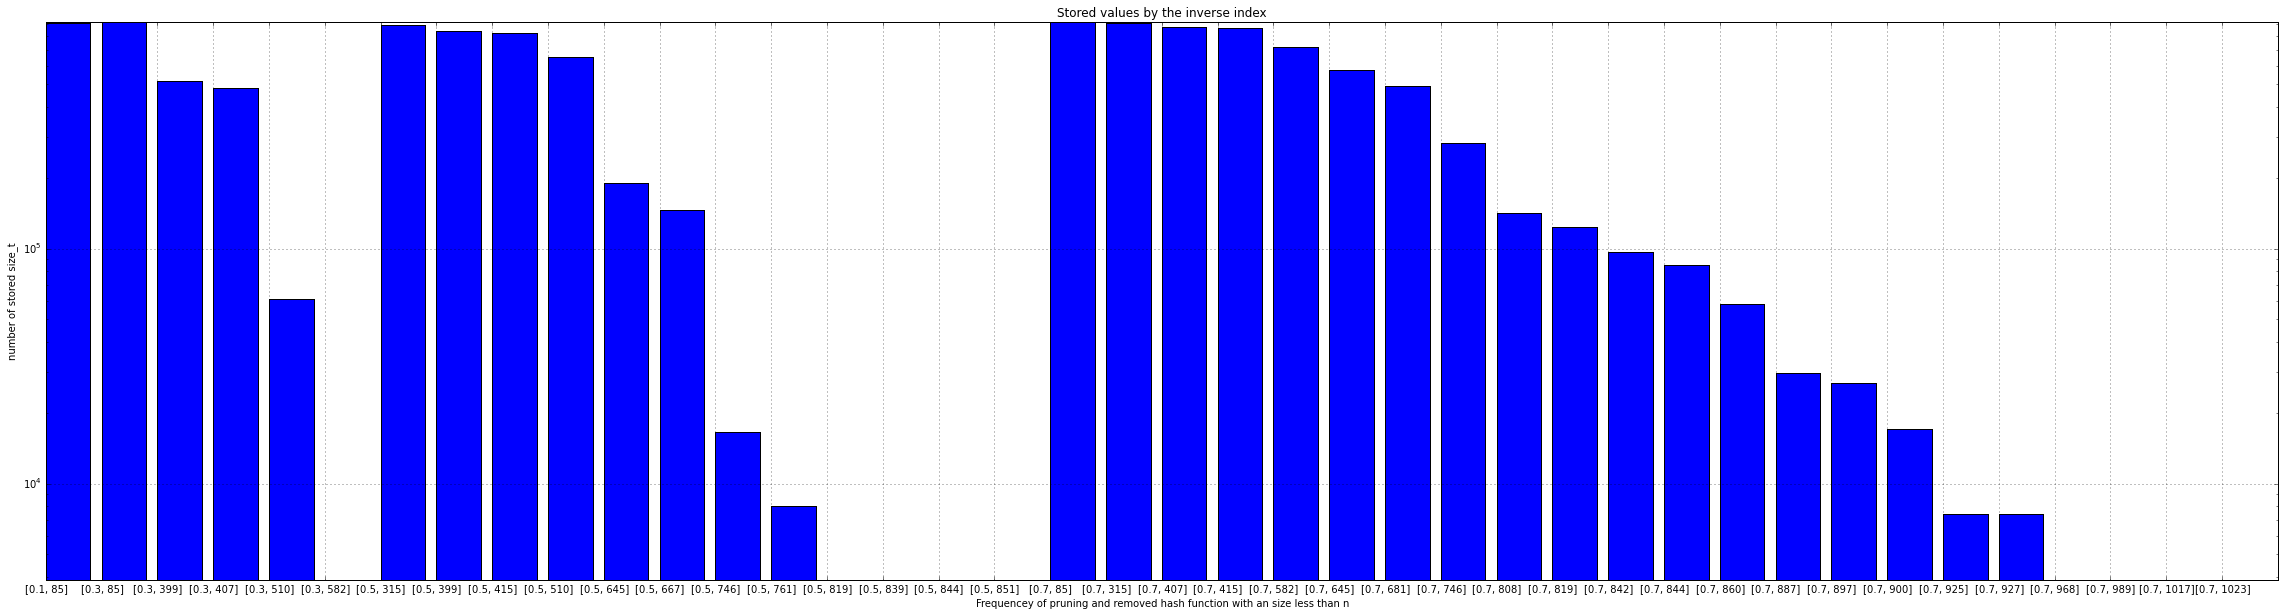

In [66]:
data = np.arange(len(memory_list[0::3]))
plt.figure(figsize=(40, 10))
plt.width=1
plt.yscale('log')
plt.bar(data, memory_list[0::3])
plt.xticks(data, iteration_value_list[0::3])
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Frequencey of pruning and removed hash function with an size less than n")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

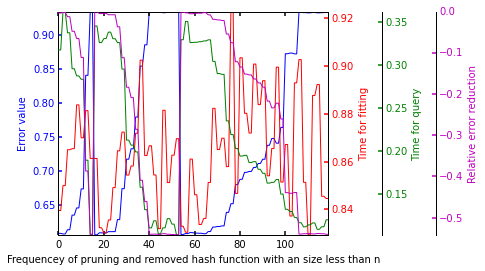

In [68]:
createPlot(range(0, len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Frequencey of pruning and removed hash function with an size less than n", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [69]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  20  with score:  1.87677129655
alpha:  0.16
beta:  1.99


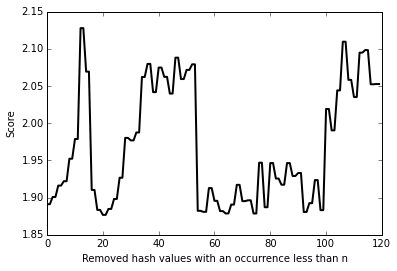

In [70]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, 
           range(0, len(iteration_value_list)),
              "Removed hash values with an occurrence less than n", "Score")

### Remove least significant n-bits

In [63]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
index_shift = 1
for i in xrange(1, 11):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/remove_least_significant_bit+"+str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)


In [64]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

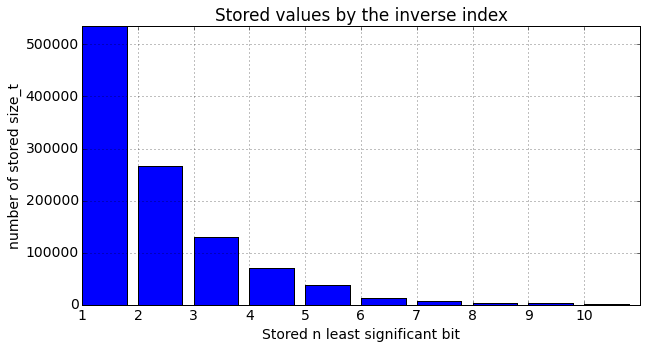

In [69]:
data = np.arange(len(memory_list))
plt.figure(figsize=(10, 5))
plt.width=1
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("Stored n least significant bit")
plt.title("Stored values by the inverse index")
plt.show()

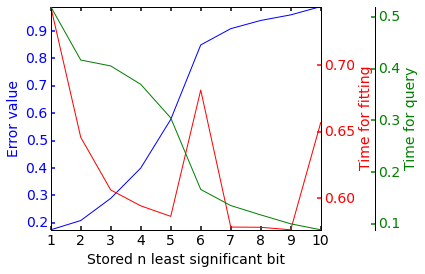

In [67]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Stored n least significant bit", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [108]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  1  with score:  1.00928590349
alpha:  0.5
beta:  0.1


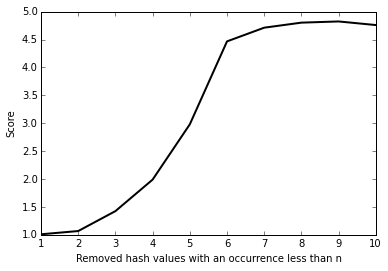

In [109]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, iteration_value_list,
              "Removed hash values with an occurrence less than n", "Score")

### All methods together

In [95]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
index_values = []
frequency_pruning = [0.5, 0.7, 1]
iteration_value_list = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
for i in [0, 1]:
    for j in [-1, 0.5]:
        for k in [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for l in iteration_value:
                for m in [4, 5]:
                    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/all+"+str(i)+ "+" +str(j)+ "+" +str(k)+ "+" +str(l)+"+" +str(m)
                    if os.path.isfile(input_file_name):
                        fileObject = open(input_file_name,'r')
                        dist_tmp = pickle.load(fileObject)
                        distribution_pruning.append(dist_tmp)
                        error_list.append(1 - dist_tmp[3])
                        time_fit_list.append(dist_tmp[1])
                        time_kneighbors_list.append(dist_tmp[2])
                        iteration_value_list.append([i,j,k,l,m])
                for m in [1, 2, 3]:
                    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/all+"+str(i)+ "+" +str(j)+ "+" +str(k)+ "+" +str(l)+"+" +str(m)
                    if os.path.isfile(input_file_name):
                        fileObject = open(input_file_name,'r')
                        dist_tmp = pickle.load(fileObject)
                        distribution_pruning.append(dist_tmp)
                        error_list.append(1 - dist_tmp[3])
                        time_fit_list.append(dist_tmp[1])
                        time_kneighbors_list.append(dist_tmp[2])
                        iteration_value_list.append([i,j,k,l,m])
                        
                
# print error_list

In [96]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list, relative_error_reduction_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

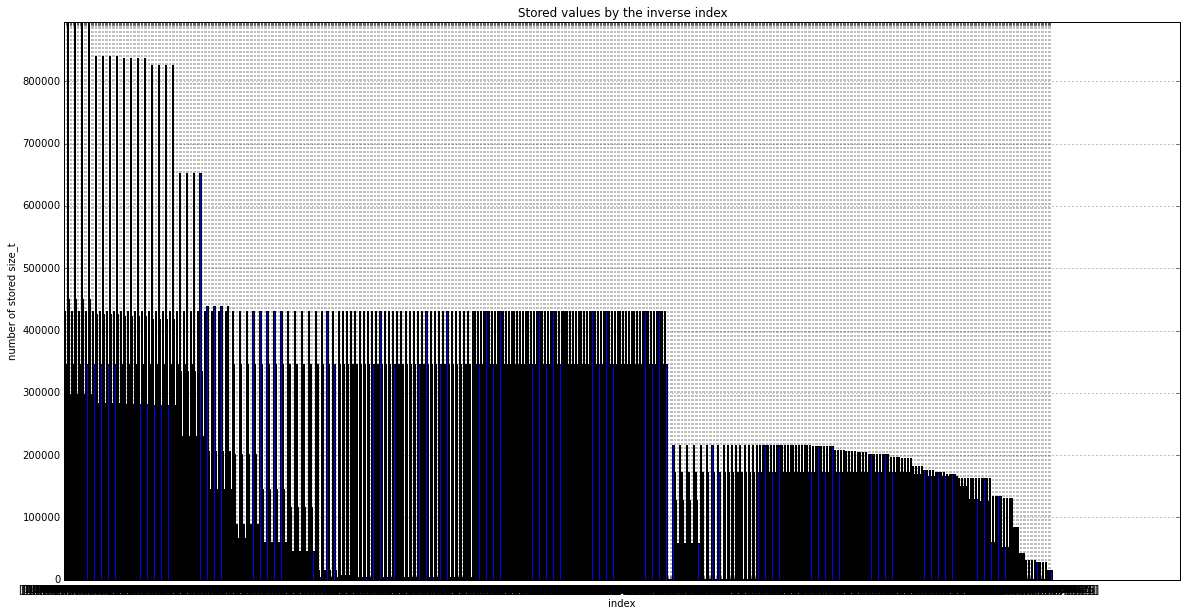

In [97]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.width=1
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("index")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

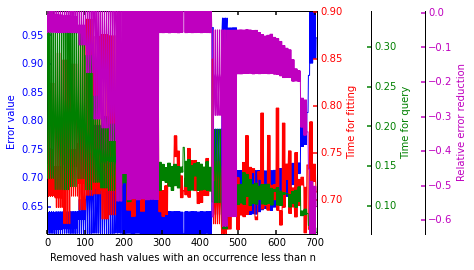

In [98]:
createPlot(range(len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, relative_error_reduction_list,
           "Removed hash values with an occurrence less than n", "Error value",
           "Time for fitting", "Time for query", "Relative error reduction")

#### Optimization for alpha and beta with respect to a minimal error value

In [99]:
best_values, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

Best value for pruning:  472  with score:  1.49824880844
alpha:  0.27
beta:  1.99


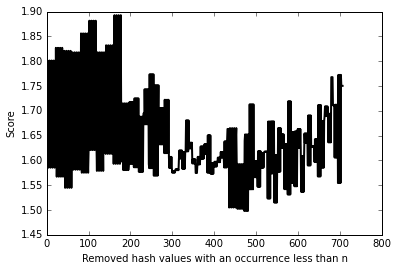

In [100]:
plot_score(best_values, error_list, memory_list, time_fit_list, max_memory, max_time, range(len(iteration_value_list)),
              "Removed hash values with an occurrence less than n", "Score")

In [103]:
print iteration_value_list[472]
print memory_list[472]
print max_memory
print error_list[472]
print max_error

[1, 0.5, -1, 407, 4]
216278
923663
0.636292367996
0.605994927369
